## Implementation of VAE for protein generation from limited sampling MSA

### General Function and Supporting Parts

In [106]:
import time
import numpy as np
from Bio import SeqIO
import sys
import scipy.io as sio
import matplotlib.pyplot as plt


In [107]:
def one_hot(a,q):
    # get a numerical np vector of integers 0:(q-1) and return its one-hot representation 
    b = np.zeros((a.size, q))
    b[np.arange(a.size),a] = 1
    return b.flatten()

def reverse_one_hot(a,q):
    # get a one-hot np vector of integers 0,1 and return its numerical representation 
    b = np.zeros((int(a.size/q)))
    b[(a.nonzero()[0]//q)]=(a.nonzero()[0]%q);
    return b

def hardmax(pred_oh,q):
    #input a vector on one-hot format with various values
    #return a vector on one-hot format with a modulo q hardmax
    return one_hot(np.argmax(np.reshape(pred_oh,(-1,q)),axis=1),q)

In [3]:
## ***** Parse from Fasta File *****

# Input fasta file ------------
file="CM.fasta"
 
# Amino acid code and error letters
code = "-ACDEFGHIKLMNPQRSTVWY"
q=len(code);
AA_to_num=dict([(code[i],i) for i in range(len(code))])
errs = "BJOUXZabcdefghijklmonpqrstuvwxyz"
AA_to_num.update(dict([(errs[i],-1) for i in range(len(errs))]))

# Parse sequence contacts of fasta into MSA
MSA=np.array([])
for record in SeqIO.parse(file, "fasta"):
    seq=np.array([[AA_to_num[record.seq[i]] for i in range(len(record.seq))]])
    if MSA.shape[0]==0:
        MSA=seq;
    else:
        MSA=np.append(MSA,seq,axis=0)
        
# Remove all errornous sequences (contain '-1')
MSA=np.delete(MSA,(np.sum(MSA==-1,axis=1)).nonzero()[0][0],axis=0)

# Transfer to One-Hot representation
MSA_oh=np.array([one_hot(a,q) for a in MSA])

# Create training and cross-valid datasets
MSA_ohr=MSA_oh[np.random.permutation(MSA_oh.shape[0]),:]
train=MSA_ohr[1:1000,:];
valid=MSA_ohr[1000:,:]

# Transfer back to numeric representation
MSA_syn=np.array([reverse_one_hot(a,q) for a in MSA_oh])

In [54]:
from keras.models import load_model, Model
from keras.layers import BatchNormalization,Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector, Concatenate, Softmax
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K
from keras import regularizers, losses

### This Part is the Deterministic Encoder

In [374]:
## ***** Determinstic Encoder-Decoder

L=MSA_oh.shape[1];
Latent=20;
inter_dim=1000;

q=21;
    # Define the input layer and specify the shape
X_input = Input(shape=(L,))
    
X = Dense(inter_dim, activation='relu')(X_input)

X = Dense(Latent)(X)

X = Dense(inter_dim, activation='relu')(X)
    
Tensor_list=[];
for i in range(int(L/q)):
    x1 = Dense(q, activation='relu')(X)
    x1 = Softmax()(x1)
    Tensor_list.append(x1)
out = Concatenate()(Tensor_list)
    
model1 = Model(inputs=[X_input], outputs=out)
model1 = Encoder_Decoder_Model(MSA_oh.shape[1])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics = ["accuracy"])
#model1.summary()

In [425]:
L=MSA_oh.shape[1];
q=21;
inter_dim=1000;
latent=20;

    # This is the encoding part - into means and sigmas fo distribution
X_input = Input(shape=(L,))
intermediate=Dense(inter_dim,activation='relu')(X_input)
z=Dense(latent,activity_regularizer=regularizers.l1(1e-5))(intermediate);

    # encoder
encoder=Model(X_input,z)
    
    # decoder
z_input=Input(shape=(latent,))
X=Dense(inter_dim,activation='relu')(z_input)
out=Dense(L,activation='sigmoid')(X)
decoder=Model(z_input,out)

    # variational autoencoder
output=decoder(encoder(X_input))
DAE=Model(X_input,output)
loss=L * losses.binary_crossentropy(X_input,output)
#KL_loss=-0.5 * K.sum(1+z_log_sigma-K.square(z_mean)-K.exp(z_log_sigma),axis=-1)
total_loss=K.mean(loss);
DAE.add_loss(total_loss)
DAE.compile(optimizer='adam',metrics='accuracy')

In [426]:
DAE.fit(MSA_oh,MSA_oh,epochs=20000)

Epoch 1/20000
40/40 [==============================] - 1s 17ms/step - loss: 454.3198 - accuracy: 0.0000e+00
Epoch 2/20000
40/40 [==============================] - 1s 17ms/step - loss: 270.1054 - accuracy: 0.0000e+00
Epoch 3/20000
40/40 [==============================] - 1s 22ms/step - loss: 232.8053 - accuracy: 0.0000e+00
Epoch 4/20000
40/40 [==============================] - 1s 26ms/step - loss: 207.1197 - accuracy: 0.0000e+00
Epoch 5/20000
40/40 [==============================] - 1s 22ms/step - loss: 191.3266 - accuracy: 0.0000e+00
Epoch 6/20000
40/40 [==============================] - 1s 20ms/step - loss: 176.3383 - accuracy: 0.0000e+00
Epoch 7/20000
40/40 [==============================] - 1s 20ms/step - loss: 164.9008 - accuracy: 0.0000e+00
Epoch 8/20000
40/40 [==============================] - 1s 20ms/step - loss: 154.6584 - accuracy: 0.0000e+00
Epoch 9/20000
40/40 [==============================] - 1s 19ms/step - loss: 145.3500 - accuracy: 0.0000e+00
Epoch 10/20000
40/40 [======

40/40 [==============================] - 1s 14ms/step - loss: 1.0097 - accuracy: 0.4197
Epoch 80/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.9066 - accuracy: 0.4245
Epoch 81/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.8717 - accuracy: 0.4300
Epoch 82/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.8335 - accuracy: 0.4316
Epoch 83/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.8041 - accuracy: 0.4332
Epoch 84/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7846 - accuracy: 0.4364
Epoch 85/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7660 - accuracy: 0.4412
Epoch 86/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7752 - accuracy: 0.4428
Epoch 87/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7316 - accuracy: 0.4436
Epoch 88/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7186 - ac

40/40 [==============================] - 1s 15ms/step - loss: 0.4692 - accuracy: 0.5246
Epoch 159/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.4685 - accuracy: 0.5254
Epoch 160/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4940 - accuracy: 0.5262
Epoch 161/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.4669 - accuracy: 0.5262
Epoch 162/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4662 - accuracy: 0.5270
Epoch 163/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4656 - accuracy: 0.5270
Epoch 164/20000
40/40 [==============================] - 1s 13ms/step - loss: 0.4913 - accuracy: 0.5278
Epoch 165/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.4643 - accuracy: 0.5278
Epoch 166/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4636 - accuracy: 0.5286
Epoch 167/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.

40/40 [==============================] - 1s 16ms/step - loss: 0.4444 - accuracy: 0.5819
Epoch 237/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.4443 - accuracy: 0.5811
Epoch 238/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4442 - accuracy: 0.5827
Epoch 239/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.4441 - accuracy: 0.5843
Epoch 240/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.4440 - accuracy: 0.5851
Epoch 241/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.4705 - accuracy: 0.5866
Epoch 242/20000
40/40 [==============================] - 1s 13ms/step - loss: 0.4704 - accuracy: 0.5882
Epoch 243/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4703 - accuracy: 0.5866
Epoch 244/20000
40/40 [==============================] - 1s 17ms/step - loss: 0.4702 - accuracy: 0.5906
Epoch 245/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.

40/40 [==============================] - 1s 15ms/step - loss: 0.4413 - accuracy: 0.6367
Epoch 315/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4413 - accuracy: 0.6375
Epoch 316/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4413 - accuracy: 0.6351
Epoch 317/20000
40/40 [==============================] - 1s 13ms/step - loss: 0.4412 - accuracy: 0.6383
Epoch 318/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4943 - accuracy: 0.6383
Epoch 319/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.4412 - accuracy: 0.6391
Epoch 320/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4412 - accuracy: 0.6375
Epoch 321/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.4412 - accuracy: 0.6407
Epoch 322/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.4677 - accuracy: 0.6391
Epoch 323/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.

40/40 [==============================] - 1s 21ms/step - loss: 0.9169 - accuracy: 0.4491
Epoch 393/20000
40/40 [==============================] - 1s 20ms/step - loss: 0.8815 - accuracy: 0.4499
Epoch 394/20000
40/40 [==============================] - 1s 19ms/step - loss: 0.9013 - accuracy: 0.4531
Epoch 395/20000
40/40 [==============================] - 1s 20ms/step - loss: 0.8682 - accuracy: 0.4539
Epoch 396/20000
40/40 [==============================] - 1s 21ms/step - loss: 0.9141 - accuracy: 0.4555
Epoch 397/20000
40/40 [==============================] - 1s 18ms/step - loss: 0.8544 - accuracy: 0.4563
Epoch 398/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8494 - accuracy: 0.4571
Epoch 399/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.8704 - accuracy: 0.4587
Epoch 400/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8656 - accuracy: 0.4634
Epoch 401/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.

40/40 [==============================] - 1s 17ms/step - loss: 0.8468 - accuracy: 0.5485
Epoch 471/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7669 - accuracy: 0.5509
Epoch 472/20000
40/40 [==============================] - 1s 18ms/step - loss: 0.7402 - accuracy: 0.5485
Epoch 473/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7929 - accuracy: 0.5517
Epoch 474/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7397 - accuracy: 0.5517
Epoch 475/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7659 - accuracy: 0.5541
Epoch 476/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7921 - accuracy: 0.5556
Epoch 477/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7388 - accuracy: 0.5556
Epoch 478/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7386 - accuracy: 0.5564
Epoch 479/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.

40/40 [==============================] - 1s 15ms/step - loss: 0.7839 - accuracy: 0.6002
Epoch 549/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7308 - accuracy: 0.6025
Epoch 550/20000
40/40 [==============================] - 1s 17ms/step - loss: 0.7573 - accuracy: 0.6017
Epoch 551/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7307 - accuracy: 0.6025
Epoch 552/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7307 - accuracy: 0.6041
Epoch 553/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7306 - accuracy: 0.6041
Epoch 554/20000
40/40 [==============================] - 1s 22ms/step - loss: 0.7306 - accuracy: 0.6057
Epoch 555/20000
40/40 [==============================] - 1s 28ms/step - loss: 0.7306 - accuracy: 0.6081
Epoch 556/20000
40/40 [==============================] - 1s 30ms/step - loss: 0.7306 - accuracy: 0.6065
Epoch 557/20000
40/40 [==============================] - 1s 31ms/step - loss: 0.

40/40 [==============================] - 1s 18ms/step - loss: 0.7560 - accuracy: 0.6383
Epoch 627/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7295 - accuracy: 0.6399
Epoch 628/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7294 - accuracy: 0.6399
Epoch 629/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7560 - accuracy: 0.6399
Epoch 630/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7825 - accuracy: 0.6383
Epoch 631/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7559 - accuracy: 0.6399
Epoch 632/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7559 - accuracy: 0.6383
Epoch 633/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7294 - accuracy: 0.6391
Epoch 634/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7559 - accuracy: 0.6391
Epoch 635/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.

40/40 [==============================] - 1s 16ms/step - loss: 0.8968 - accuracy: 0.4690
Epoch 705/20000
40/40 [==============================] - 1s 20ms/step - loss: 0.9184 - accuracy: 0.4698
Epoch 706/20000
40/40 [==============================] - 1s 21ms/step - loss: 0.8868 - accuracy: 0.4714
Epoch 707/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.8812 - accuracy: 0.4730
Epoch 708/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.9033 - accuracy: 0.4754
Epoch 709/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.8735 - accuracy: 0.4785
Epoch 710/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.8689 - accuracy: 0.4777
Epoch 711/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.8658 - accuracy: 0.4793
Epoch 712/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8889 - accuracy: 0.4825
Epoch 713/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.

40/40 [==============================] - 1s 15ms/step - loss: 0.7957 - accuracy: 0.5572
Epoch 783/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7955 - accuracy: 0.5580
Epoch 784/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.8483 - accuracy: 0.5604
Epoch 785/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7951 - accuracy: 0.5612
Epoch 786/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8742 - accuracy: 0.5636
Epoch 787/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8478 - accuracy: 0.5668
Epoch 788/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7946 - accuracy: 0.5660
Epoch 789/20000
40/40 [==============================] - 1s 17ms/step - loss: 0.7944 - accuracy: 0.5676
Epoch 790/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.8207 - accuracy: 0.5676
Epoch 791/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.

40/40 [==============================] - 1s 16ms/step - loss: 0.8158 - accuracy: 0.6184
Epoch 861/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7892 - accuracy: 0.6184
Epoch 862/20000
40/40 [==============================] - 1s 17ms/step - loss: 0.7892 - accuracy: 0.6200
Epoch 863/20000
40/40 [==============================] - 1s 17ms/step - loss: 0.7892 - accuracy: 0.6208
Epoch 864/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8157 - accuracy: 0.6216
Epoch 865/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8422 - accuracy: 0.6224
Epoch 866/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7891 - accuracy: 0.6232
Epoch 867/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8156 - accuracy: 0.6256
Epoch 868/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.7891 - accuracy: 0.6264
Epoch 869/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.

40/40 [==============================] - 1s 16ms/step - loss: 0.7884 - accuracy: 0.6510
Epoch 939/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.8414 - accuracy: 0.6502
Epoch 940/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8149 - accuracy: 0.6494
Epoch 941/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7883 - accuracy: 0.6494
Epoch 942/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7883 - accuracy: 0.6494
Epoch 943/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8148 - accuracy: 0.6494
Epoch 944/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7883 - accuracy: 0.6502
Epoch 945/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7883 - accuracy: 0.6502
Epoch 946/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.7883 - accuracy: 0.6510
Epoch 947/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.

40/40 [==============================] - 1s 15ms/step - loss: 0.9032 - accuracy: 0.4102
Epoch 1017/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8811 - accuracy: 0.4118
Epoch 1018/20000
40/40 [==============================] - 1s 17ms/step - loss: 0.8622 - accuracy: 0.4141
Epoch 1019/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8468 - accuracy: 0.4213
Epoch 1020/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.8341 - accuracy: 0.4229
Epoch 1021/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.8225 - accuracy: 0.4277
Epoch 1022/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.8125 - accuracy: 0.4285
Epoch 1023/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.8039 - accuracy: 0.4308
Epoch 1024/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7948 - accuracy: 0.4324
Epoch 1025/20000
40/40 [==============================] - 1s 15ms/step -

40/40 [==============================] - 1s 16ms/step - loss: 0.6873 - accuracy: 0.5445
Epoch 1095/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.6870 - accuracy: 0.5445
Epoch 1096/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.7133 - accuracy: 0.5453
Epoch 1097/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.6866 - accuracy: 0.5461
Epoch 1098/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.6864 - accuracy: 0.5493
Epoch 1099/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.6862 - accuracy: 0.5517
Epoch 1100/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.6860 - accuracy: 0.5509
Epoch 1101/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.6858 - accuracy: 0.5548
Epoch 1102/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.6856 - accuracy: 0.5556
Epoch 1103/20000
40/40 [==============================] - 1s 16ms/step -

40/40 [==============================] - 1s 16ms/step - loss: 0.6800 - accuracy: 0.6089
Epoch 1173/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.6800 - accuracy: 0.6105
Epoch 1174/20000
40/40 [==============================] - 1s 14ms/step - loss: 0.6800 - accuracy: 0.6113
Epoch 1175/20000
40/40 [==============================] - 1s 17ms/step - loss: 0.6799 - accuracy: 0.6113
Epoch 1176/20000
40/40 [==============================] - 1s 15ms/step - loss: 0.6799 - accuracy: 0.6113
Epoch 1177/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.6799 - accuracy: 0.6121
Epoch 1178/20000
40/40 [==============================] - 1s 16ms/step - loss: 0.6799 - accuracy: 0.6121
Epoch 1179/20000
40/40 [==============================] - 1s 23ms/step - loss: 0.7064 - accuracy: 0.6121
Epoch 1180/20000
40/40 [==============================] - 1s 26ms/step - loss: 0.6798 - accuracy: 0.6137
Epoch 1181/20000
40/40 [==============================] - 1s 22ms/step -

KeyboardInterrupt: 

In [376]:
preds = DAE.evaluate(x = MSA_oh, y = MSA_oh)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

40/40 [==============================] - 0s 6ms/step - loss: 0.0521 - accuracy: 0.3514

Loss = 0.05206234008073807
Test Accuracy = 0.3513513505458832


In [432]:
pred=(DAE.predict(MSA_oh))
pred_hm=np.array([hardmax(a,q) for a in pred])
pred_num=np.array([reverse_one_hot(a,q) for a in pred_hm])
saver={"align_bm":(pred_num+1)}
sio.savemat("DAE_pred.mat", saver)

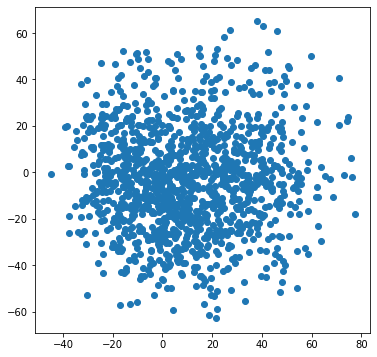

In [431]:
z_vals=np.array(encoder.predict(MSA_oh))
plt.figure(figsize=(6, 6))
plt.scatter(z_vals[:,5], z_vals[:, 0])
#plt.colorbar()
plt.show()

In [434]:
rand_z=(np.random.rand(1000,latent)*60-30)
pred=(decoder.predict(rand_z))
pred_hm=np.array([hardmax(a,q) for a in pred])
pred_num=np.array([reverse_one_hot(a,q) for a in pred_hm])
saver={"align_bm":(pred_num+1)}
sio.savemat("DAE_gen.mat", saver)

### Here we implement the Variational Version - VAE

In [101]:
## ***** Variationl Autoencoder

L=MSA_oh.shape[1];
q=21;
inter_dim=1000;
latent=3;
lam0=1;
    # This is the encoding part - into means and sigmas fo distribution
X_input = Input(shape=(L,))
intermediate=Dense(inter_dim,activation='relu')(X_input)
intermediate=Dropout(.1)(intermediate)
z_mean=Dense(latent)(intermediate);
z_log_sigma=Dense(latent)(intermediate);

    # distribution layer
def distribution(args):
    z_mean,z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0],latent),mean=0,stddev=0.1)
    return z_mean+K.exp(z_log_sigma)*epsilon

z = Lambda(distribution)([z_mean, z_log_sigma])
#z = Dropout(.2)(z)
    # encoder
encoder=Model(X_input,[z_mean,z_log_sigma,z])
    
    # decoder
z_input=Input(shape=(latent,))
X=Dense(inter_dim,activation='relu')(z_input)
out=Dense(L,activation='sigmoid')(X)
decoder=Model(z_input,out)

    # variational autoencoder
output=decoder(encoder(X_input)[2])
VAE=Model(X_input,output)
loss=L * losses.binary_crossentropy(X_input,output)
KL_loss=-lam0*0.5 * K.sum(1+z_log_sigma-K.square(z_mean)-K.exp(z_log_sigma),axis=-1)
total_loss=K.mean(loss+KL_loss);
VAE.add_loss(total_loss)
VAE.compile(optimizer='adam',metrics=['accuracy'])

In [102]:
fitting=VAE.fit(MSA_ohr,MSA_ohr,epochs=182,validation_split=0.205,batch_size=50)

Epoch 1/182
20/20 [==============================] - 1s 42ms/step - loss: 709.8528 - accuracy: 0.0000e+00 - val_loss: 369.1939 - val_accuracy: 0.0000e+00
Epoch 2/182
20/20 [==============================] - 1s 36ms/step - loss: 341.3953 - accuracy: 0.0000e+00 - val_loss: 319.9069 - val_accuracy: 0.0000e+00
Epoch 3/182
20/20 [==============================] - 1s 42ms/step - loss: 306.3322 - accuracy: 0.0000e+00 - val_loss: 302.6137 - val_accuracy: 0.0000e+00
Epoch 4/182
20/20 [==============================] - 1s 39ms/step - loss: 290.5309 - accuracy: 0.0000e+00 - val_loss: 287.9253 - val_accuracy: 0.0000e+00
Epoch 5/182
20/20 [==============================] - 1s 37ms/step - loss: 271.3064 - accuracy: 0.0000e+00 - val_loss: 274.1490 - val_accuracy: 0.0000e+00
Epoch 6/182
20/20 [==============================] - 1s 44ms/step - loss: 257.9641 - accuracy: 0.0000e+00 - val_loss: 265.7670 - val_accuracy: 0.0000e+00
Epoch 7/182
20/20 [==============================] - 1s 37ms/step - loss: 24

Epoch 54/182
20/20 [==============================] - 1s 32ms/step - loss: 185.5091 - accuracy: 0.0000e+00 - val_loss: 222.3967 - val_accuracy: 0.0000e+00
Epoch 55/182
20/20 [==============================] - 1s 33ms/step - loss: 185.0262 - accuracy: 0.0000e+00 - val_loss: 221.8070 - val_accuracy: 0.0000e+00
Epoch 56/182
20/20 [==============================] - 1s 34ms/step - loss: 184.5777 - accuracy: 0.0000e+00 - val_loss: 221.7013 - val_accuracy: 0.0000e+00
Epoch 57/182
20/20 [==============================] - 1s 32ms/step - loss: 184.1113 - accuracy: 0.0000e+00 - val_loss: 221.4600 - val_accuracy: 0.0000e+00
Epoch 58/182
20/20 [==============================] - 1s 32ms/step - loss: 183.8328 - accuracy: 0.0000e+00 - val_loss: 221.1586 - val_accuracy: 0.0000e+00
Epoch 59/182
20/20 [==============================] - 1s 33ms/step - loss: 183.5363 - accuracy: 0.0000e+00 - val_loss: 221.1515 - val_accuracy: 0.0000e+00
Epoch 60/182
20/20 [==============================] - 1s 33ms/step - l

Epoch 107/182
20/20 [==============================] - 1s 34ms/step - loss: 168.9302 - accuracy: 0.0000e+00 - val_loss: 216.4613 - val_accuracy: 0.0000e+00
Epoch 108/182
20/20 [==============================] - 1s 34ms/step - loss: 168.6964 - accuracy: 0.0000e+00 - val_loss: 216.2966 - val_accuracy: 0.0000e+00
Epoch 109/182
20/20 [==============================] - 1s 34ms/step - loss: 168.4867 - accuracy: 0.0000e+00 - val_loss: 215.8884 - val_accuracy: 0.0000e+00
Epoch 110/182
20/20 [==============================] - 1s 35ms/step - loss: 167.9347 - accuracy: 0.0000e+00 - val_loss: 215.8479 - val_accuracy: 0.0000e+00
Epoch 111/182
20/20 [==============================] - 1s 34ms/step - loss: 167.7908 - accuracy: 0.0000e+00 - val_loss: 215.8177 - val_accuracy: 0.0000e+00
Epoch 112/182
20/20 [==============================] - 1s 33ms/step - loss: 167.6955 - accuracy: 0.0000e+00 - val_loss: 215.4500 - val_accuracy: 0.0000e+00
Epoch 113/182
20/20 [==============================] - 1s 35ms/s

20/20 [==============================] - 1s 36ms/step - loss: 159.0126 - accuracy: 0.0000e+00 - val_loss: 214.6880 - val_accuracy: 0.0000e+00
Epoch 160/182
20/20 [==============================] - 1s 38ms/step - loss: 158.7930 - accuracy: 0.0000e+00 - val_loss: 214.5787 - val_accuracy: 0.0000e+00
Epoch 161/182
20/20 [==============================] - 1s 38ms/step - loss: 158.6043 - accuracy: 0.0000e+00 - val_loss: 215.0386 - val_accuracy: 0.0000e+00
Epoch 162/182
20/20 [==============================] - 1s 37ms/step - loss: 158.5619 - accuracy: 0.0000e+00 - val_loss: 215.2563 - val_accuracy: 0.0000e+00
Epoch 163/182
20/20 [==============================] - 1s 37ms/step - loss: 158.4976 - accuracy: 0.0000e+00 - val_loss: 214.5134 - val_accuracy: 0.0000e+00
Epoch 164/182
20/20 [==============================] - 1s 37ms/step - loss: 158.2422 - accuracy: 0.0000e+00 - val_loss: 214.9442 - val_accuracy: 0.0000e+00
Epoch 165/182
20/20 [==============================] - 1s 37ms/step - loss: 15

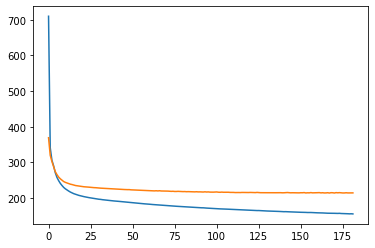

In [103]:
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])

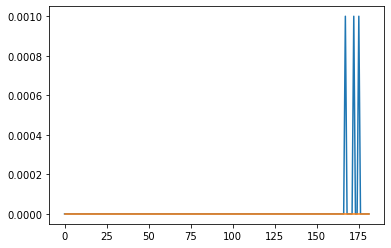

In [104]:
plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])

In [47]:
results = VAE.evaluate(valid, valid, batch_size=50)
print("test loss, test acc:", results)

6/6 [==============================] - 0s 7ms/step - loss: 307.9253 - accuracy: 0.0543
test loss, test acc: [307.92529296875, 0.05426356568932533]


In [105]:
pred=(VAE.predict(MSA_oh))
#pred=(decoder.predict(rand_z))
pred_hm=np.array([hardmax(a,q) for a in pred])
pred_num=np.array([reverse_one_hot(a,q) for a in pred_hm])
saver={"align_bm":(pred_num+1)}
sio.savemat("VAE_pred.mat", saver)

rand_z=(np.random.rand(1258,latent)*4-2)
pred=(decoder.predict(rand_z))
pred_hm=np.array([hardmax(a,q) for a in pred])
pred_num=np.array([reverse_one_hot(a,q) for a in pred_hm])
saver={"align_bm":(pred_num+1)}
sio.savemat("VAE_gen.mat", saver)

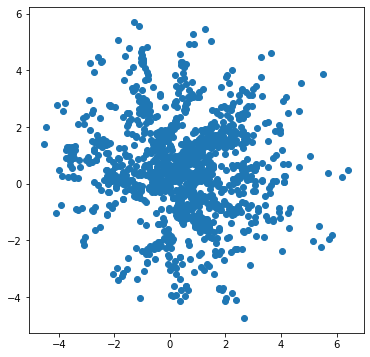

In [97]:
z_vals=np.array(encoder.predict(MSA_oh))
plt.figure(figsize=(6, 6))
plt.scatter(z_vals[2,:,0], z_vals[2,:, 2])
#plt.colorbar()
plt.show()